In [1]:
%load_ext autoreload
%autoreload 2

Pytorch EO is designed to work with any combination of inputs-outputs to enable applications such as unsupervised learning (no outputs), data fusion (multiple inputs), multi task learning (multiple outputs) and any combination.

To do so we define Pytorch `Datasets` for each input and output modality (i.e images and metadata for inputs and labels, bounding boxes, masks, etc, for outputs). For training, we create a `ConcatDataset` to iterate over the desired combination of inputs-outputs.

Our design philosophy is to load data as `numpy` arrays. For images, we keep channels last. We use `albumentations` por data augmentation. 

The following code will download the EuroSAT dataset RGB version.

In [2]:
import os
from pytorch_eo.utils import download_url, unzip_file
from pathlib import Path

path = Path('data')
os.makedirs(path, exist_ok=True)

url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
compressed_data_filename = 'EuroSAT.zip'
compressed_data_path = path / compressed_data_filename
download_url(url, compressed_data_path)

unzip_file(compressed_data_path, path, msg="extracting data ...")

extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 12027.07it/s]


Now we can find our images and labels. Each dataset may have its own pre-processing steps, in this case the labels are encoded in the folder name and images can be found inside each folder.

In [3]:
data_folder = '2750'
uncompressed_data_path = path / data_folder
classes = sorted(os.listdir(uncompressed_data_path))
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [4]:
import pandas as pd

images, labels = [], []
for ix, label in enumerate(classes):
    _images = os.listdir(uncompressed_data_path / label)
    images += [str(uncompressed_data_path /
                label / img) for img in _images]
    labels += [ix]*len(_images)

df = pd.DataFrame({'image': images, 'label': labels})

df.sample(5)

,image,label
19530,data/2750/Residential/Residential_1601.jpg,7
23178,data/2750/River/River_2247.jpg,8
25017,data/2750/SeaLake/SeaLake_42.jpg,9
20866,data/2750/Residential/Residential_482.jpg,7
22637,data/2750/River/River_1979.jpg,8


Nevertheless, we will always end up with the same: a list of paths to images and the corresponding labels (or bounding boxes, segmentation masks, ...), pairs of inputs-outputs to feed and train our model.

## Data splits

The first thing that we need is to split our data in train and test. This is important for reproducibility (comparing our results to others) as long as we use the same splits. Sometimes this splits will already be provided, in this case we build them ourselves. Additionally, we may want to use a validation split for hyperparameter optimization. 

First, we need a dataset. Albumentations need some required fields (image, mask, ...), for now we can pass the 'image' field if other names are used.

In [11]:
from pytorch_eo.utils.datasets.RGBImageDataset import RGBImageDataset
from pytorch_eo.utils.datasets.ConcatDataset import ConcatDataset

images_ds = RGBImageDataset(images)
labels_ds = labels

# pass inputs and outputs as dicts, so we know where to apply transforms 

ds = ConcatDataset({'abc': images_ds, 'label': labels_ds}) #not valid

AssertionError: a valid image field must be provided to albumentations

In [12]:
ds = ConcatDataset({'abc': images_ds, 'label': labels_ds}, image_field='abc') # ok, the 'abc' field will be used as the 'image' field

In [8]:
ds = ConcatDataset({'abc': images_ds, 'label': labels_ds}, image_field='abc') # ok, the 'abc' field will be used as the 'image' field

In [13]:
ds = ConcatDataset({'image': images_ds, 'label': labels_ds}) # ok

len(ds)

27000

The dataset will contain all the available samples. We can retrieve them by their keys.

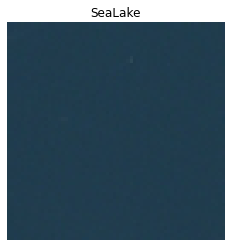

In [20]:
import random 
import matplotlib.pyplot as plt

ix = random.randint(0, len(ds)-1)

sample = ds[ix]
img, label = sample['image'], sample['label']

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.imshow(img) # unit8 (h, w, c)
ax.set_title(classes[label])
ax.axis('off')
plt.show()

In order to train a model, we will need a DataLoader. This is the objet responsible for efficiently loading data and batching it.  

In [21]:
from torch.utils.data import DataLoader

dl = DataLoader(ds, batch_size=3)

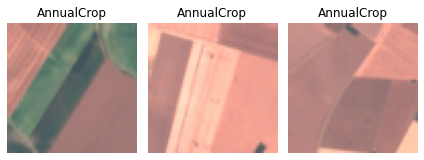

In [26]:
def plot_batch(batch):
    imgs, labels = batch['image'], batch['label']
    fig = plt.figure()
    for ix, (img, label) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(1,len(imgs), ix + 1)
        ax.imshow(img)
        ax.set_title(classes[label.item()])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

batch = next(iter(dl))
plot_batch(batch)

In [27]:
dl = DataLoader(ds, batch_size=3, shuffle=True)

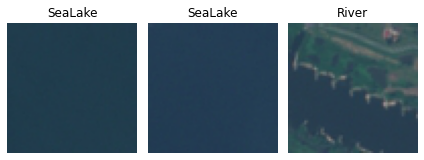

In [31]:
batch = next(iter(dl))
plot_batch(batch)

### Train-Test splits

In [32]:
test_size = 0.2 # use 20% of the data for testing
idxs = list(range(len(df)))
testset_len = int(len(df)*test_size)
trainset_len = len(df) - testset_len

trainset_len, testset_len

(21600, 5400)

Use last 20% of the data for testing

In [33]:
train_df = df[:trainset_len]
test_df = df[trainset_len:]

len(train_df), len(test_df)

(21600, 5400)

This can be problematic in some cases (unbalanced class distributions)

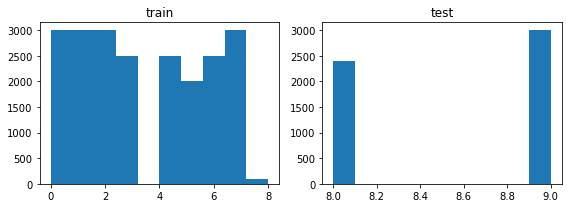

In [34]:
import numpy as np

def plot_class_balance(train_df, test_df):
    fig = plt.figure(figsize=(8, 3))
    ax = plt.subplot(1,2,1)
    ax.hist(train_df.label, bins=len(classes))
    ax.set_title('train')
    ax = plt.subplot(1,2,2)
    ax.hist(test_df.label, bins=len(classes))
    ax.set_title('test')
    plt.tight_layout()
    plt.show()

plot_class_balance(train_df, test_df)

Better to random split given size and a seed (use same size and seed to compare with others).

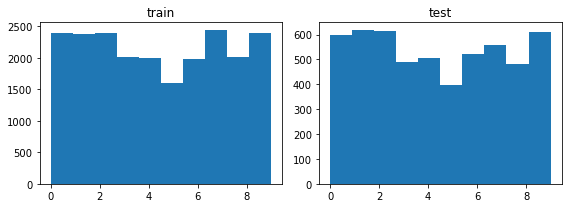

In [35]:
from sklearn.model_selection import train_test_split

seed = 21
train_df, test_df = train_test_split(df, test_size=test_size, random_state=seed)

plot_class_balance(train_df, test_df)

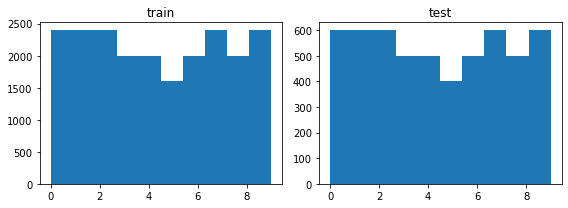

In [36]:
# or better yet, stratify by label

seed = 42
train_df, test_df = train_test_split(df, test_size=test_size, stratify=df.label, random_state=seed)

plot_class_balance(train_df, test_df)

### Validation split

Use a subset of training data

In [37]:
val_size = 0.2 # use 20% of the training data for validating
valset_len = int(len(df)*val_size)
trainset2_len = trainset_len - valset_len

trainset2_len, valset_len, testset_len

(16200, 5400, 5400)

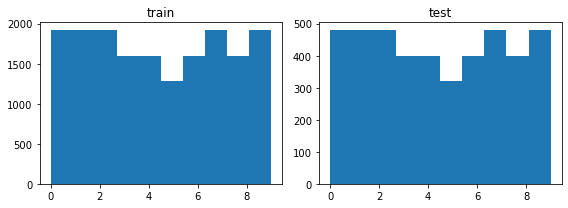

In [38]:
train_df2, val_df = train_test_split(train_df, test_size=val_size, stratify=train_df.label, random_state=seed)

plot_class_balance(train_df2, val_df)

Or use cross validation

In [39]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
skf.get_n_splits(train_df)

5

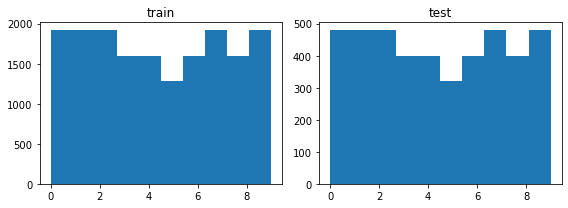

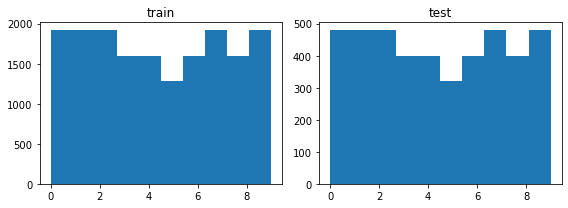

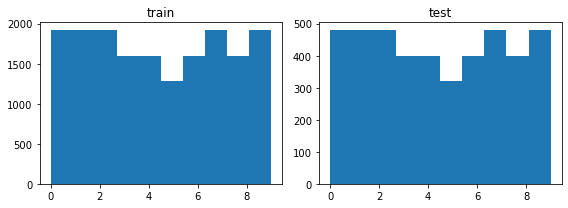

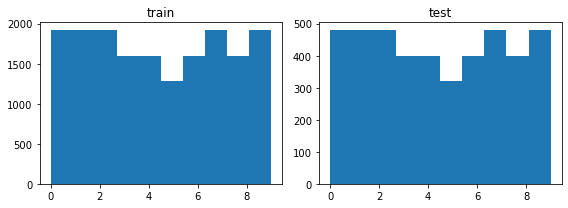

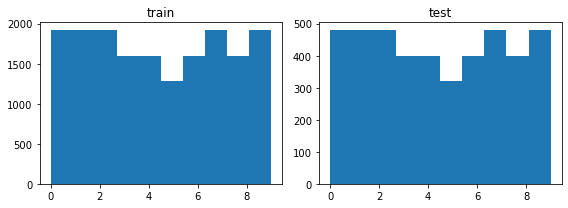

In [40]:
for train_ixs, val_ixs in skf.split(train_df, train_df.label):
    plot_class_balance(train_df.iloc[train_ixs], train_df.iloc[val_ixs])